In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd.functional import jvp
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_s_curve

random_state = 42

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, z):
        return self.fc(z)

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder, data_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.data_dim = data_dim
        self.latent_dim = latent_dim
    
    def forward(self, x):
        # Encode the input data
        z = self.encoder(x)
        
        # Decode the latent representation
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed
    
    def encode(self, x):
        # Encode the input data to get the latent representation
        with torch.no_grad():
            z = self.encoder(x)
        return z
    
    def decode(self, z):
        # Decode the latent representation to get the reconstructed data
        with torch.no_grad():
            x_reconstructed = self.decoder(z)
        return x_reconstructed
    
    def get_loss(self, x):
        # Compute the reconstruction loss
        x_reconstructed = self.forward(x)
        loss = nn.MSELoss()(x_reconstructed, x)
        return loss
    
    def train(self, data, epochs=1000, batch_size=64, learning_rate=0.001):        
        # Define loss function and optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        # Training loop
        for epoch in range(epochs):
            for i in range(0, len(data), batch_size):
                batch_data = data[i:i+batch_size]

                # Compute loss
                loss = self.get_loss(batch_data)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
class IsotropicAutoencoder(Autoencoder):
    def __init__(self, encoder, decoder, data_dim, latent_dim):
        super(IsotropicAutoencoder, self).__init__(encoder, decoder, data_dim, latent_dim)
        self.encoder = encoder
        self.decoder = decoder
        self.data_dim = data_dim
        self.latent_dim = latent_dim
    
    def get_loss(self, x):
        # Compute the isotropic loss
        z = self.encoder(x)
        # distortion = self.relaxed_distortion_measure(self.decoder, z)
        distortion = self.isometry_loss(self.decoder, z)
        x_reconstructed = self.decoder(z)
        mse = nn.MSELoss()(x_reconstructed, x) + 0.5 * torch.mean(torch.norm(z, dim=1)**2)
        loss = mse + 0*distortion
        # print(f"Distortion: {distortion.item():.8f}")
        # print(f"Reconstruction Loss: {mse.item():.8f}")
        return loss
    
    def relaxed_distortion_measure(self, func, z, eta=0.2, create_graph=True):
        '''
        func: decoder that maps "latent value z" to "data", where z.size() == (batch_size, latent_dim)
        '''
        bs = len(z)
        z_perm = z[torch.randperm(bs)] #?
        alpha = (torch.rand(bs) * (1 + 2*eta) - eta).unsqueeze(1).to(z) #?
        z_augmented = alpha*z + (1-alpha)*z_perm #?
        # z_augmented = z
        v = torch.randn(z.size()).to(z)
        Jv = torch.autograd.functional.jvp(
            func, z_augmented, v=v, create_graph=create_graph)[1]
        TrG = torch.sum(Jv.view(bs, -1)**2, dim=1).mean()
        JTJv = (torch.autograd.functional.vjp(
            func, z_augmented, v=Jv, create_graph=create_graph)[1]).view(bs, -1)
        TrG2 = torch.sum(JTJv**2, dim=1).mean()
        return TrG2/TrG**2
    
    def isometry_loss(self, func, z, epsilon=1e-8):
        """
        z: (batch_size, latent_dim) latent vectors sampled from Piso
        """
        
        # Sample u ~ Uniform(S^{d-1}), i.e., unit vector on sphere
        u = torch.randn_like(z)
        u = u / (u.norm(dim=1, keepdim=True) + epsilon)

        # Compute Jv = df(z) @ u
        Jv = jvp(func, z, u, create_graph=True)[1]

        # Compute norm of Jv and apply the isometric loss
        Jv_norm = Jv.norm(dim=1)
        loss = ((Jv_norm - 1.0) ** 2).mean()
        
        return loss

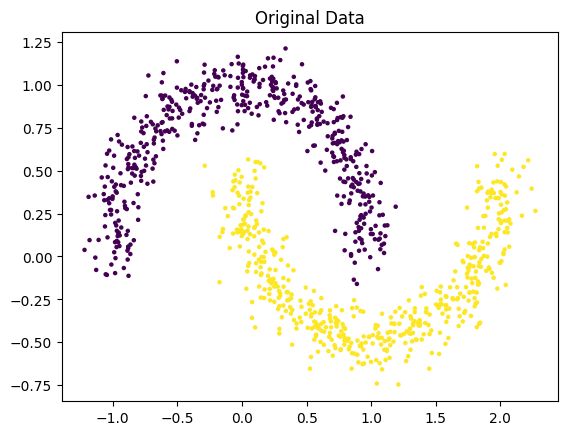

In [11]:
data, labels = make_moons(n_samples=1000, noise=0.1, shuffle=True, random_state=random_state)
data = torch.tensor(data, dtype=torch.float32)
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Original Data")
plt.show()

In [6]:
encoder = Encoder(input_dim=2, latent_dim=1)
decoder = Decoder(latent_dim=1, output_dim=2)
autoencoder = Autoencoder(encoder, decoder, data_dim=2, latent_dim=1)

autoencoder.train(data)

Epoch [100/1000], Loss: 0.0082
Epoch [200/1000], Loss: 0.0076
Epoch [300/1000], Loss: 0.0072
Epoch [400/1000], Loss: 0.0075
Epoch [500/1000], Loss: 0.0071
Epoch [600/1000], Loss: 0.0070
Epoch [700/1000], Loss: 0.0067
Epoch [800/1000], Loss: 0.0063
Epoch [900/1000], Loss: 0.0067
Epoch [1000/1000], Loss: 0.0062


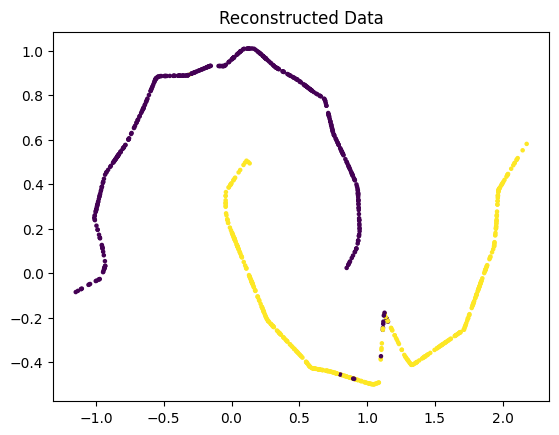

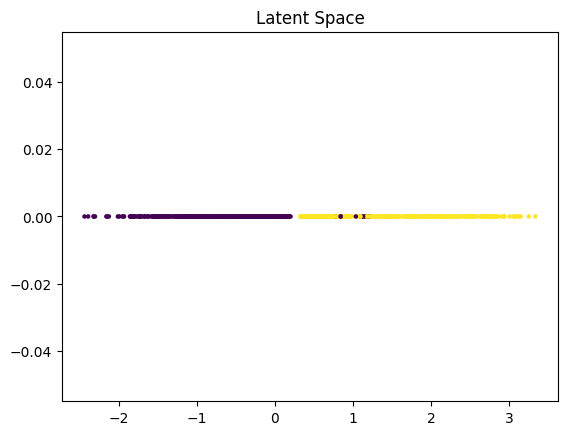

In [7]:
# Encode the data
encoded_data = autoencoder.encode(data)
# Decode the data
decoded_data = autoencoder.decode(encoded_data)

# Visualize the reconstruction
plt.scatter(decoded_data[:, 0], decoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Reconstructed Data")
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], torch.zeros_like(encoded_data[:, 0]), c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [12]:
encoder = Encoder(input_dim=2, latent_dim=1)
decoder = Decoder(latent_dim=1, output_dim=2)
isotropic_autoencoder = IsotropicAutoencoder(encoder, decoder, data_dim=2, latent_dim=1)

isotropic_autoencoder.train(data)

Epoch [100/1000], Loss: 0.2368
Epoch [200/1000], Loss: 0.2374
Epoch [300/1000], Loss: 0.2384
Epoch [400/1000], Loss: 0.2381
Epoch [500/1000], Loss: 0.2387
Epoch [600/1000], Loss: 0.2405
Epoch [700/1000], Loss: 0.2404
Epoch [800/1000], Loss: 0.2404
Epoch [900/1000], Loss: 0.2390
Epoch [1000/1000], Loss: 0.2371


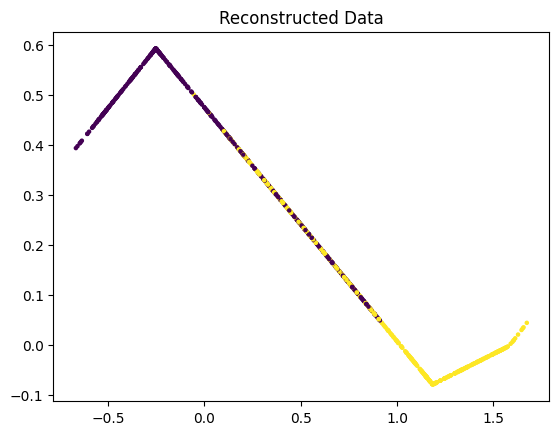

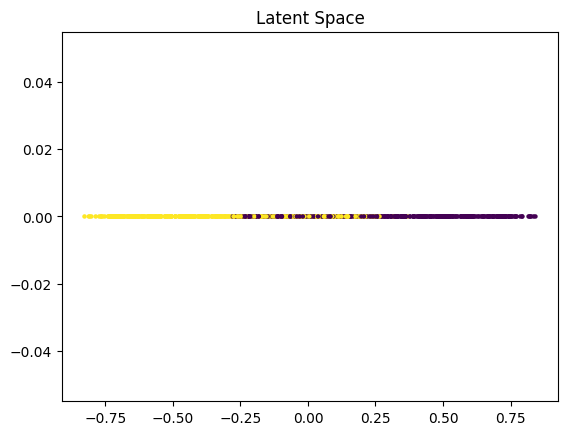

In [13]:
# Encode the data
encoded_data = isotropic_autoencoder.encode(data)
# Decode the data
decoded_data = isotropic_autoencoder.decode(encoded_data)

# Visualize the reconstruction
plt.scatter(decoded_data[:, 0], decoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Reconstructed Data")
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], torch.zeros_like(encoded_data[:, 0]), c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

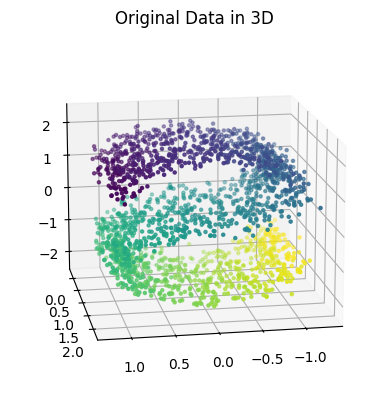

In [19]:
data, labels = make_s_curve(n_samples=2000, noise=0.1, random_state=random_state)
data = torch.tensor(data, dtype=torch.float32)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 80, 0)
plt.show()

In [68]:
encoder = Encoder(input_dim=3, latent_dim=2)
decoder = Decoder(latent_dim=2, output_dim=3)
autoencoder = Autoencoder(encoder, decoder, data_dim=3, latent_dim=2)
autoencoder.train(data)

Epoch [100/1000], Loss: 0.0026
Epoch [200/1000], Loss: 0.0030
Epoch [300/1000], Loss: 0.0021
Epoch [400/1000], Loss: 0.0020
Epoch [500/1000], Loss: 0.0021
Epoch [600/1000], Loss: 0.0018
Epoch [700/1000], Loss: 0.0016
Epoch [800/1000], Loss: 0.0020
Epoch [900/1000], Loss: 0.0017
Epoch [1000/1000], Loss: 0.0017


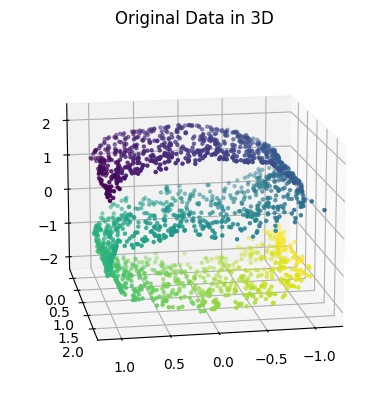

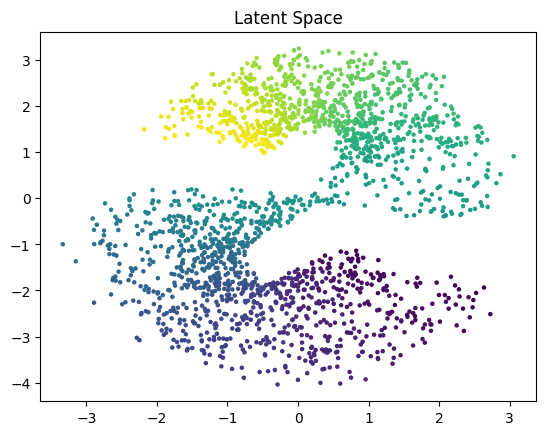

In [69]:
#Encode the data
encoded_data = autoencoder.encode(data)
# Decode the data
decoded_data = autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 80, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [70]:
num = 900
J = torch.zeros((num, 2, 2))
for i in range(num):
    latent = encoder(data[i:i+1])
    jac = torch.autograd.functional.jacobian(decoder, latent)
    jac = jac[0,:,0,:]
    J[i] = jac.T @ jac
J.mean(dim=0)

tensor([[ 1.3612, -0.2365],
        [-0.2365,  1.5607]])

In [20]:
encoder = Encoder(input_dim=3, latent_dim=2)
decoder = Decoder(latent_dim=2, output_dim=3)
isotropic_autoencoder = IsotropicAutoencoder(encoder, decoder, data_dim=3, latent_dim=2)
isotropic_autoencoder.train(data, epochs=1000)

Epoch [100/1000], Loss: 0.0404
Epoch [200/1000], Loss: 0.0141
Epoch [300/1000], Loss: 0.0110
Epoch [400/1000], Loss: 0.0059
Epoch [500/1000], Loss: 0.0056
Epoch [600/1000], Loss: 0.0049
Epoch [700/1000], Loss: 0.0046
Epoch [800/1000], Loss: 0.0042
Epoch [900/1000], Loss: 0.0041
Epoch [1000/1000], Loss: 0.0035


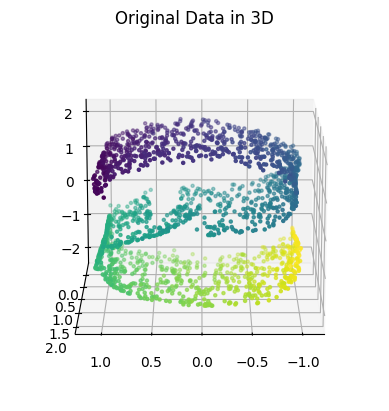

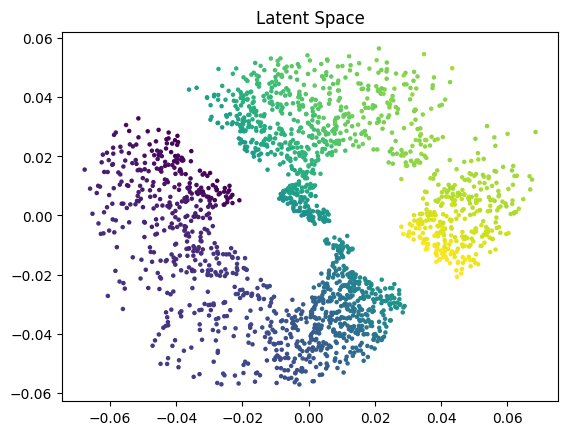

In [21]:
#Encode the data
encoded_data = isotropic_autoencoder.encode(data)
# Decode the data
decoded_data = isotropic_autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 90, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [34]:
num = 900
J = torch.zeros((num, 2, 2))
for i in range(num):
    latent = encoder(data[i:i+1])
    jac = torch.autograd.functional.jacobian(decoder, latent)
    jac = jac[0,:,0,:]
    J[i] = jac.T @ jac
J.mean(dim=0)

tensor([[ 1.0596, -0.0494],
        [-0.0494,  1.0268]])

In [30]:
(J.mean(dim=0) / 5.4753)

tensor([[ 0.8737, -0.2894],
        [-0.2894,  1.0000]])

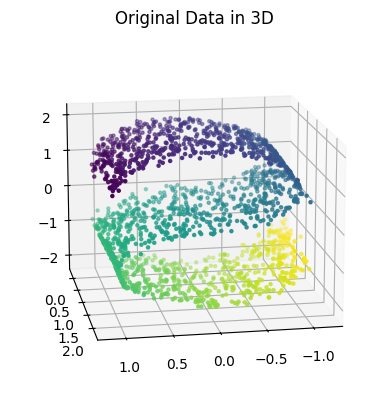

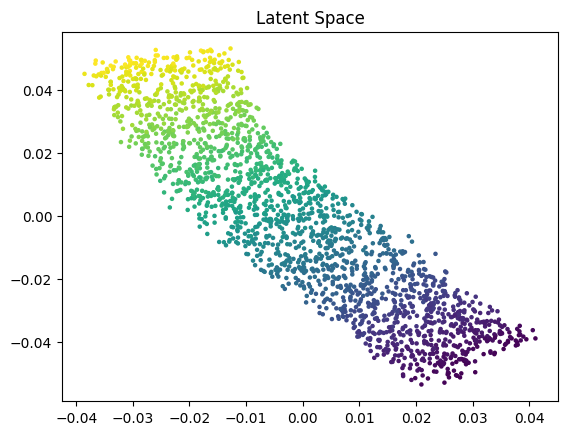

In [56]:
#Encode the data
encoded_data = isotropic_autoencoder.encode(data)
# Decode the data
decoded_data = isotropic_autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(15, 80, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [62]:
def make_halve_sphere(n_samples=1000, noise=0.1, random_state=None):
    """
    Generate a half-sphere dataset.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Generate random points on a sphere
    phi = np.random.uniform(0, np.pi, n_samples)
    theta = np.random.uniform(0, 2 * np.pi, n_samples)
    
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    # Keep only the upper hemisphere
    mask = z >= 0
    x = x[mask]
    y = y[mask]
    z = z[mask]
    
    # Add noise
    noise_x = np.random.normal(0, noise, x.shape)
    noise_y = np.random.normal(0, noise, y.shape)
    noise_z = np.random.normal(0, noise, z.shape)
    
    x += noise_x
    y += noise_y
    z += noise_z

    labels = z
    
    return np.column_stack((x, y, z)), labels

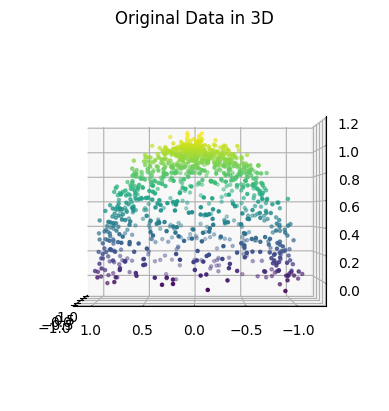

In [63]:
data, labels = make_halve_sphere(n_samples=2000, noise=0.05, random_state=random_state)
data = torch.tensor(data, dtype=torch.float32)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, s=5)
ax.set_title("Original Data in 3D")
ax.view_init(0, 180, 0)
plt.show()

In [64]:
encoder = Encoder(input_dim=3, latent_dim=2)
decoder = Decoder(latent_dim=2, output_dim=3)
isotropic_autoencoder = IsotropicAutoencoder(encoder, decoder, data_dim=3, latent_dim=2)
isotropic_autoencoder.train(data, epochs=1000)

Epoch [100/1000], Loss: 0.7892
Epoch [200/1000], Loss: 0.4786
Epoch [300/1000], Loss: 0.5731
Epoch [400/1000], Loss: 0.4854
Epoch [500/1000], Loss: 0.5542
Epoch [600/1000], Loss: 0.6475
Epoch [700/1000], Loss: 0.5744
Epoch [800/1000], Loss: 0.5328
Epoch [900/1000], Loss: 0.7167
Epoch [1000/1000], Loss: 0.9238


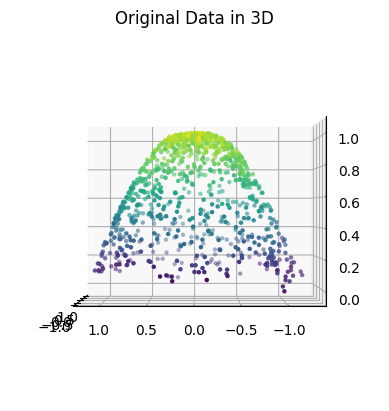

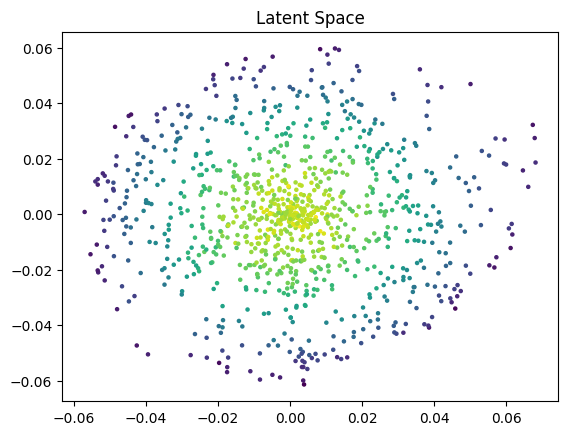

In [65]:
#Encode the data
encoded_data = isotropic_autoencoder.encode(data)
# Decode the data
decoded_data = isotropic_autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(0, 180, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [66]:
num = 900
J = torch.zeros((num, 2, 2))
for i in range(num):
    latent = encoder(data[i:i+1])
    jac = torch.autograd.functional.jacobian(decoder, latent)
    jac = jac[0,:,0,:]
    J[i] = jac.T @ jac
J.mean(dim=0)

tensor([[611.3881,  -3.3357],
        [ -3.3357, 642.0032]])

In [27]:
encoder = Encoder(input_dim=3, latent_dim=2)
decoder = Decoder(latent_dim=2, output_dim=3)
autoencoder = Autoencoder(encoder, decoder, data_dim=3, latent_dim=2)
autoencoder.train(data)

Epoch [100/1000], Loss: 0.0005
Epoch [200/1000], Loss: 0.0005
Epoch [300/1000], Loss: 0.0004
Epoch [400/1000], Loss: 0.0004
Epoch [500/1000], Loss: 0.0004
Epoch [600/1000], Loss: 0.0003
Epoch [700/1000], Loss: 0.0003
Epoch [800/1000], Loss: 0.0003
Epoch [900/1000], Loss: 0.0003
Epoch [1000/1000], Loss: 0.0003


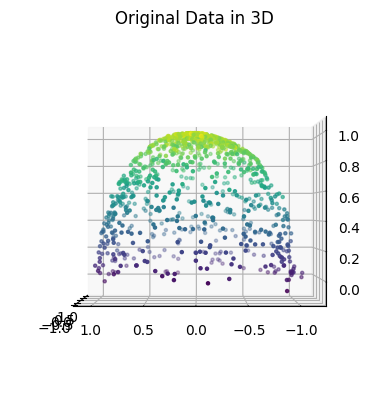

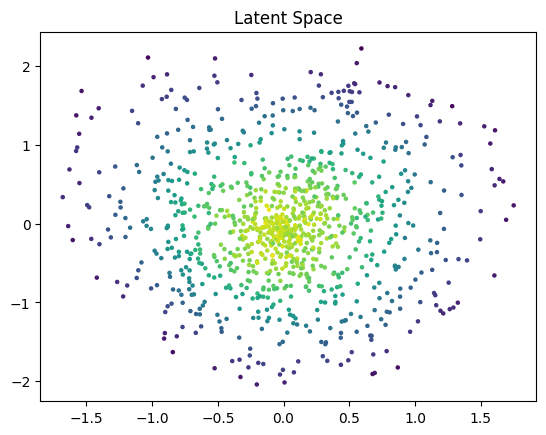

In [28]:
#Encode the data
encoded_data = autoencoder.encode(data)
# Decode the data
decoded_data = autoencoder.decode(encoded_data)

# Visualize the reconstruction
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(decoded_data[:, 0], decoded_data[:, 1], decoded_data[:, 2], c=labels, cmap='viridis', s=5)
ax.set_title("Original Data in 3D")
ax.view_init(0, 180, 0)
plt.show()
# Visualize the latent space
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title("Latent Space")
plt.show()

In [61]:
num = 900
J = torch.zeros((num, 2, 2))
for i in range(num):
    latent = encoder(data[i:i+1])
    jac = torch.autograd.functional.jacobian(decoder, latent)
    jac = jac[0,:,0,:]
    J[i] = jac.T @ jac
J.mean(dim=0)

tensor([[1.0679, 0.0114],
        [0.0114, 0.6186]])